# Graph Neuronal Networks

In [1]:
# Librerías

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import torch
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv 
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Datos

edges = pd.read_csv("../data/raw/musae_git_edges.csv")
features = pd.read_csv("../data/raw/musae_git_features.csv")
target = pd.read_csv("../data/raw/musae_git_target.csv")

Convertir los datos a tensores


In [3]:
# Edgelist a tensor
edge_index = torch.tensor(edges.values.T, dtype=torch.long)
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1) # Grafo no dirigido


# Features a tensor (multihot encoder)
num_nodes = target.shape[0]  
num_features = features["feature"].nunique()  

x = torch.zeros((num_nodes, num_features), dtype=torch.float)
for row in features.itertuples(index=False):
    node_id, feature_id = row  
    x[node_id, feature_id] = 1

# Target a tensor
y = torch.tensor(target["ml_target"].values, dtype=torch.long)

# Lo metemos todo en la estructura Data de PyG
data = Data(x=x, edge_index=edge_index, y=y)

División aleatoria en train, validation, and test 

In [4]:
num_nodes = data.x.size(0)  
indices = torch.randperm(num_nodes)  

# Proporciones 60 - 20 -20
train_size = int(0.6 * num_nodes)  
val_size = int(0.2 * num_nodes)  
test_size = num_nodes - train_size - val_size  

train_mask = indices[:train_size]
val_mask = indices[train_size:train_size + val_size]
test_mask = indices[train_size + val_size:]

# Creamos las máscaras
data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[train_mask] = 1  
data.val_mask[val_mask] = 1  
data.test_mask[test_mask] = 1  

Especificamos el device a emplear y movemos todo los datos a este.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
data = data.to(device)
x = x.to(device)
edge_index = data.edge_index.to(device)
data.y = data.y.to(device)
data.train_mask = data.train_mask.to(device)
data.val_mask = data.val_mask.to(device)
data.test_mask = data.test_mask.to(device) 

Definimos el modelo: GNN con dos capas, activación relu y dropout

In [7]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 2)  

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)  
        x = F.dropout(x, training=self.training)  
        x = self.conv2(x, edge_index)  
        x = F.relu(x)  
        x = F.dropout(x, training=self.training)  
        x = self.conv3(x, edge_index) 
        return x # Usaremos cross_entropy que toma los raw logits

In [8]:
# Consideraremos embeddings de dimensión 10 en las capas ocultas y una tasas de aprendizaje de 0.01

model = GCN(hidden_channels=100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) 

Metrica de evaluación

In [9]:
# Tasa de acierto equilibrada

def balanced_accuracy(pred, labels, mask):
    
    pred = pred[mask]
    labels = labels[mask]
    
    TP_0 = ((pred == 0) & (labels == 0)).sum().item()  
    FN_0 = ((pred != 0) & (labels == 0)).sum().item()  
    TP_1 = ((pred == 1) & (labels == 1)).sum().item()  
    FN_1 = ((pred != 1) & (labels == 1)).sum().item()  
    

    recall_0 = TP_0 / (TP_0 + FN_0) if (TP_0 + FN_0) != 0 else 0
    recall_1 = TP_1 / (TP_1 + FN_1) if (TP_1 + FN_1) != 0 else 0
    
    return (recall_0 + recall_1) / 2

Función de pérdida

In [10]:
# Entropía cruzada dando 4 veces más peso a la clase minoritaria (0)
class_weights = torch.tensor([1.0,10.0]).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)

Entrenamiento - Validación

In [11]:
def train():
    model.train()
    optimizer.zero_grad() 
    out = model(x, data.edge_index) 
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward() # Retropropagación
    optimizer.step() # Actualizar los pesos
    return loss.item()

def validation():
    model.eval()
    out = model(x, data.edge_index)
    pred = out.argmax(dim=1) 
    val_acc = balanced_accuracy(pred, data.y, data.val_mask)
    train_acc = balanced_accuracy(pred, data.y, data.train_mask)
    return val_acc, train_acc

¿Cuántas épocas emplear para entrenar el modelo?

Epoch: 001, Training Loss: 0.6936, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch: 002, Training Loss: 0.5659, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch: 003, Training Loss: 0.5676, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch: 004, Training Loss: 0.5079, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch: 005, Training Loss: 0.4938, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch: 006, Training Loss: 0.4640, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch: 007, Training Loss: 0.4316, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch: 008, Training Loss: 0.4199, Train Accuracy: 0.5000, Val Accuracy: 0.5000
Epoch: 009, Training Loss: 0.4027, Train Accuracy: 0.5001, Val Accuracy: 0.5003
Epoch: 010, Training Loss: 0.3869, Train Accuracy: 0.5603, Val Accuracy: 0.5591
Epoch: 011, Training Loss: 0.3806, Train Accuracy: 0.7123, Val Accuracy: 0.7067
Epoch: 012, Training Loss: 0.3771, Train Accuracy: 0.7693, Val Accuracy: 0.7641
Epoch: 013, Training Loss: 0.3755, Train

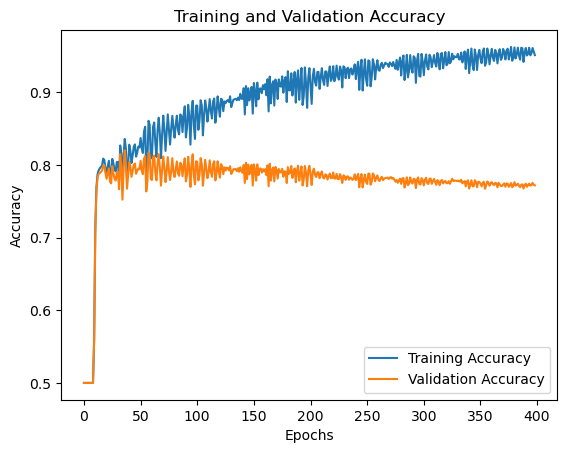

Se alcanzó 0.8201278001534357 en la época 36


In [12]:
train_acc_list =[]
val_acc_list = []

for epoch in range(1, 400):
    loss = train()
    res = validation()
    val_acc, train_acc = res
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    print(f'Epoch: {epoch:03d}, Training Loss: {loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}')

plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

n_epochs = torch.tensor(val_acc_list).argmax()
max_acc = max(val_acc_list)
print(f"Se alcanzó {max_acc} en la época {n_epochs}")

Juntamos los datos de entrenamiento y validación para reentrenar el modelo en 100 epocas y evaluamos el rendimiento en test

In [ ]:
# Combinar los datos de entrenamiento y validación
data.train_mask = data.train_mask | data.val_mask 

# Reentrenar el modelo con el conjunto de entrenamiento + validación
model.train()  
optimizer.zero_grad()  

for epoch in range(50):
    optimizer.zero_grad()
    out = model(x, data.edge_index)  # Obtener las predicciones del modelo
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()  
    optimizer.step()  
    if epoch % 10 == 0:  # Imprimir el progreso cada 10 épocas
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluar el modelo en el conjunto test
model.eval()  
with torch.no_grad(): 
    out = model(x, data.edge_index)  
    pred = out.argmax(dim=1)
    # Evaluación en el conjunto de prueba
    test_acc = balanced_accuracy(pred, data.y, data.test_mask)
print(f'Balanced accuracy en Test: {test_acc}')

Epoch 0, Loss: 0.5094929337501526
Epoch 10, Loss: 0.26913461089134216
Epoch 20, Loss: 0.21917206048965454
Epoch 30, Loss: 0.19712620973587036
Epoch 40, Loss: 0.18146318197250366
Balanced accuracy en Test: 0.7799159981857805


In [14]:
cm = pd.crosstab(pred[data.test_mask].cpu(),data.y[data.test_mask].cpu(), normalize=1)

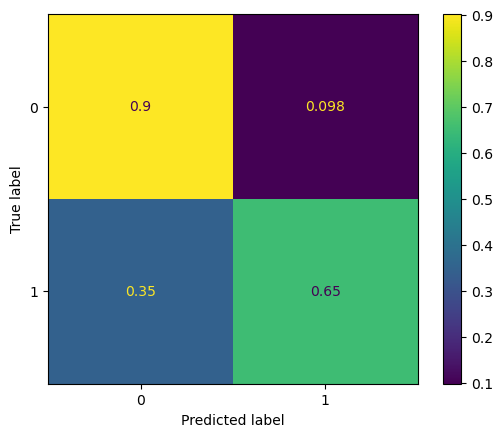

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=data.y[data.test_mask].cpu(),
                      y_pred=pred[data.test_mask].cpu(),
                      normalize="true")
disp = ConfusionMatrixDisplay(cm)
disp.plot()